# Trading behavior and Overall Market sentiment Analysis


Importing required dependencies

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import os

plt.rcParams['figure.figsize'] = (10,5)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

Reading Data files

In [88]:

trades_path = 'historical_data.csv'
sentiment_path = 'fear_greed_index.csv'

# Loading
if not os.path.exists(trades_path):
    raise FileNotFoundError(f"Trades file not found: {trades_path}")
if not os.path.exists(sentiment_path):
    raise FileNotFoundError(f"Sentiment file not found: {sentiment_path}")

df_trades = pd.read_csv(trades_path)
df_sent = pd.read_csv(sentiment_path)

print('Shape of the TRADES:', df_trades.shape)
print(df_trades.head().T)
print('\nSHAPE OF THE SENTIMENT:', df_sent.shape)
print(df_sent.head().T)

Shape of the TRADES: (211224, 16)
                                                                  0  \
Account                  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   
Coin                                                           @107   
Execution Price                                              7.9769   
Size Tokens                                                  986.87   
Size USD                                                    7872.16   
Side                                                            BUY   
Timestamp IST                                      02-12-2024 22:50   
Start Position                                                  0.0   
Direction                                                       Buy   
Closed PnL                                                      0.0   
Transaction Hash  0xec09451986a1874e3a980418412fcd0201f500c95bac...   
Order ID                                                52017706630   
Crossed                                    

## Column mapping

In [89]:

trader_id_col = 'Account'
timestamp_col = 'Timestamp IST'
entry_col = 'Execution Price'
exit_col = 'Execution Price'
size_col = 'Size USD'
direction_col = 'Direction'
pnl_col = 'Closed PnL'

sent_date_col = 'date'
sent_value_col = 'value'


Handling Missing Values

In [90]:
# Checking for missing values
# Sentiment
print('\nSentiment dtypes:')
print(df_sent.dtypes)
print('\nMissing in sentiment:')
print(df_sent.isna().sum())

# Trades
print(df_trades.dtypes)
print('\nMissing in trades:')
print(df_trades.isna().sum())



# Converting timestamp and date
try:
    df_trades[timestamp_col] = pd.to_datetime(df_trades[timestamp_col], format='%d-%m-%Y %H:%M', errors='coerce')
except Exception as e:
    print('timestamp conversion error:', e)

try:
    df_sent[sent_date_col] = pd.to_datetime(df_sent[sent_date_col], errors='coerce')
except Exception as e:
    print('sentiment date conversion error:', e)


# Create date columns for daily aggregation
if timestamp_col in df_trades.columns:
    df_trades['date'] = pd.to_datetime(df_trades[timestamp_col].dt.date)
else:
    print('timestamp column is not found')

print('\nAfter conversions:')

cols_to_print = [col for col in [timestamp_col, 'date'] if col in df_trades.columns]
if cols_to_print:
    print(df_trades[cols_to_print].head())
else:
    print("Timestamp or date column not found in df_trades after processing.")

print(df_sent[[sent_date_col, sent_value_col]].head())


Sentiment dtypes:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Missing in sentiment:
timestamp         0
value             0
classification    0
date              0
dtype: int64
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

Missing in trades:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Cross

EDA

In [91]:
# Compute PnL if not present
if pnl_col in df_trades.columns and df_trades[pnl_col].notna().any():
    print('Using existing pnl column')
    df_trades['pnl'] = df_trades[pnl_col]
else:
    # Try to compute from entry/exit/size/direction
    if all(c in df_trades.columns for c in [entry_col, exit_col, size_col]):
        print('Computing pnl from entry/exit/size/direction (if direction not present, assumes long)')
        if direction_col not in df_trades.columns:
            df_trades[direction_col] = 1
        df_trades['pnl'] = (df_trades[exit_col] - df_trades[entry_col]) * df_trades[size_col] * df_trades[direction_col]
    else:
        print('Cannot compute pnl: missing required columns. Please provide a pnl column or relevant names in the mapping cell.')

print('pnls example:')
print(df_trades[['date','pnl']].head())

# Drop rows which have no date or pnl
df_trades = df_trades.dropna(subset=['date','pnl'])
print('After dropping missing date/pnl:', df_trades.shape)

Using existing pnl column
pnls example:
        date  pnl
0 2024-12-02  0.0
1 2024-12-02  0.0
2 2024-12-02  0.0
3 2024-12-02  0.0
4 2024-12-02  0.0
After dropping missing date/pnl: (211224, 18)


In [92]:
# Aggregate per-trader daily metrics

# Rename the trader ID column based on the mapping
df_trades = df_trades.rename(columns={trader_id_col: 'trader_id'})

agg = df_trades.groupby(['trader_id','date']).agg(
    trades_count = ('pnl','count'),
    total_pnl = ('pnl','sum'),
    avg_pnl = ('pnl','mean'),
    win_rate = ('pnl', lambda x: (x>0).mean()),
    std_pnl = ('pnl','std')
).reset_index()

# Replace NaN std with 0
agg['std_pnl'] = agg['std_pnl'].fillna(0)

# Rolling metrics
agg = agg.sort_values(['trader_id','date'])
agg['rolling_pnl_7d'] = agg.groupby('trader_id')['total_pnl'].transform(lambda x: x.rolling(7, min_periods=1).mean())

print('Aggregated sample:')
print(agg.head())
print('\nAgg shape:', agg.shape)

Aggregated sample:
                                    trader_id       date  trades_count  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11           177   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-17            68   
2  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-18            40   
3  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-22            12   
4  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-26            27   

   total_pnl      avg_pnl  win_rate      std_pnl  rolling_pnl_7d  
0        0.0     0.000000  0.000000     0.000000            0.00  
1        0.0     0.000000  0.000000     0.000000            0.00  
2        0.0     0.000000  0.000000     0.000000            0.00  
3   -21227.0 -1768.916667  0.000000  1526.178379        -5306.75  
4     1603.1    59.374074  0.444444   172.316814        -3924.78  

Agg shape: (2341, 8)


In [93]:
# Prepare sentiment series
# ensure a 'date' column in df_sent with no time component
if sent_date_col in df_sent.columns:
    df_sent['date'] = pd.to_datetime(df_sent[sent_date_col]).dt.date
    df_sent['date'] = pd.to_datetime(df_sent['date'])
else:
    raise KeyError('Sentiment date column not found. Update mapping.')

# renaming the sentiment value
if sent_value_col in df_sent.columns:
    df_sent = df_sent.rename(columns={sent_value_col:'fear_greed_value'})
else:
    raise KeyError('Sentiment score column not found. Update mapping.')

# If multiple records per date, we will take mean
sent_daily = df_sent.groupby('date')['fear_greed_value'].mean().reset_index().sort_values('date')
# forward fill missing dates by reindexing full date range
date_idx = pd.date_range(sent_daily['date'].min(), sent_daily['date'].max())
sent_daily = sent_daily.set_index('date').reindex(date_idx).rename_axis('date').reset_index()
sent_daily['fear_greed_value'] = sent_daily['fear_greed_value'].ffill()

print('Sentiment sample:')
print(sent_daily.head())
print('\nSentiment range:', sent_daily['fear_greed_value'].min(), 'to', sent_daily['fear_greed_value'].max())

Sentiment sample:
        date  fear_greed_value
0 2018-02-01              30.0
1 2018-02-02              15.0
2 2018-02-03              40.0
3 2018-02-04              24.0
4 2018-02-05              11.0

Sentiment range: 5.0 to 95.0


In [94]:
# Merging sentiment into agg by using date
agg = agg.merge(sent_daily, how='left', on='date')
agg = agg.sort_values(['trader_id','date'])

print('Merged sample:')
print(agg.head())

Merged sample:
                                    trader_id       date  trades_count  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11           177   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-17            68   
2  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-18            40   
3  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-22            12   
4  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-26            27   

   total_pnl      avg_pnl  win_rate      std_pnl  rolling_pnl_7d  \
0        0.0     0.000000  0.000000     0.000000            0.00   
1        0.0     0.000000  0.000000     0.000000            0.00   
2        0.0     0.000000  0.000000     0.000000            0.00   
3   -21227.0 -1768.916667  0.000000  1526.178379        -5306.75   
4     1603.1    59.374074  0.444444   172.316814        -3924.78   

   fear_greed_value  
0              76.0  
1              90.0  
2              83.0  
3              94.0  
4              79.0  

Plotting Graphs

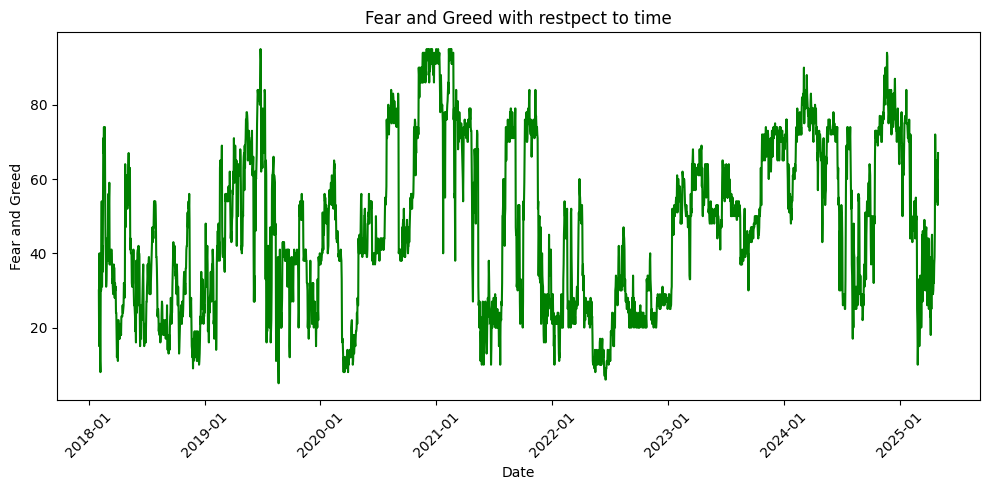

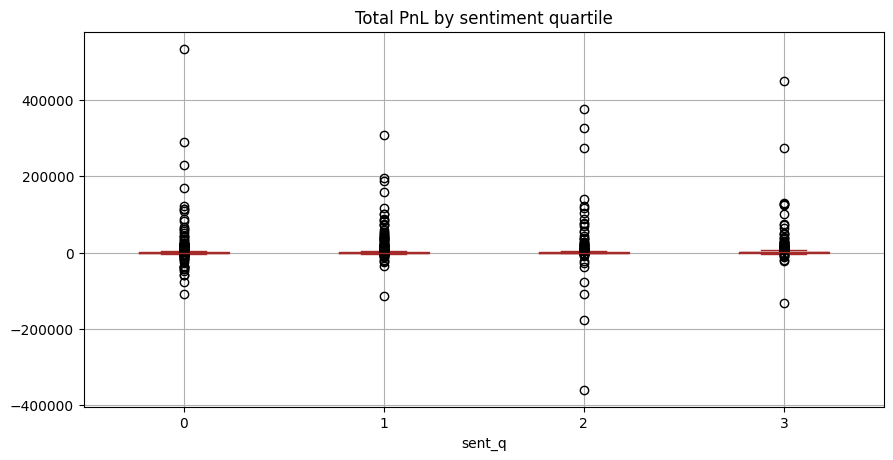

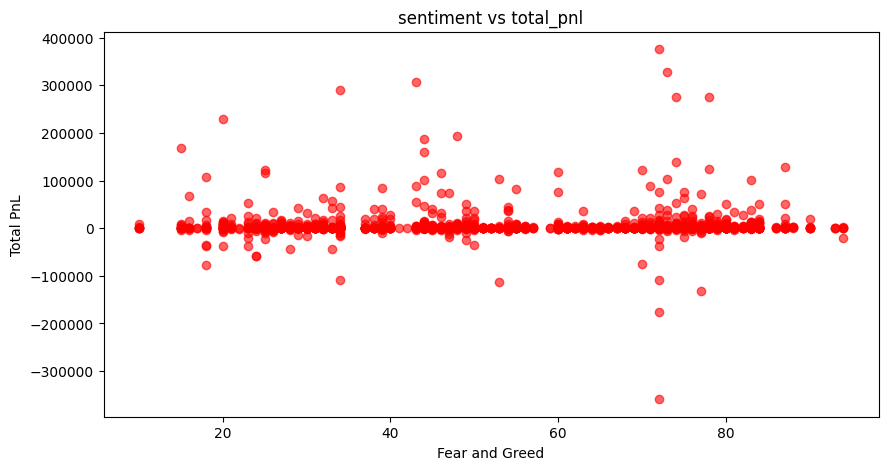

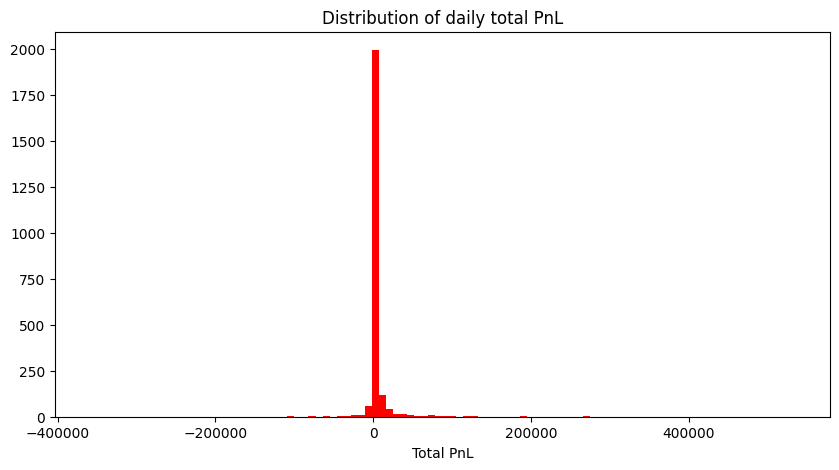

In [95]:
# EDA

#Sentiment over time
fig, a = plt.subplots()
a.plot(sent_daily['date'], sent_daily['fear_greed_value'],color='green')
a.set_title('Fear and Greed with restpect to time')
a.set_xlabel('Date')
a.set_ylabel('Fear and Greed')
a.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#Boxplot of total_pnl by sentiment quartile
agg['sent_q'] = pd.qcut(agg['fear_greed_value'], q=4, labels=False, duplicates='drop')
fig, a = plt.subplots()
agg.boxplot(column='total_pnl', by='sent_q', ax=a,color='brown')
a.set_title('Total PnL by sentiment quartile')
plt.suptitle('')
plt.show()

#Scatter sentiment vs total_pnl
sample = agg.sample(min(2000, len(agg)), random_state=42)
fig, s = plt.subplots()
s.scatter(sample['fear_greed_value'], sample['total_pnl'], alpha=0.6, color='red')
s.set_xlabel('Fear and Greed')
s.set_ylabel('Total PnL')
s.set_title('sentiment vs total_pnl')
plt.show()

#daily total_pnl
fig, b = plt.subplots()
b.hist(agg['total_pnl'].dropna(), bins=100, color='red')
b.set_xlabel('Total PnL')
b.set_title('Distribution of daily total PnL')
plt.show()

Correlation of total_pnl with sentiment lags (0..5):
{0: np.float64(0.0006552234574174165), 1: np.float64(-0.008697215078537487), 2: np.float64(-0.009023459403292496), 3: np.float64(-0.005708497009535124), 4: np.float64(0.005986634563894434), 5: np.float64(0.0020708986730119845)}


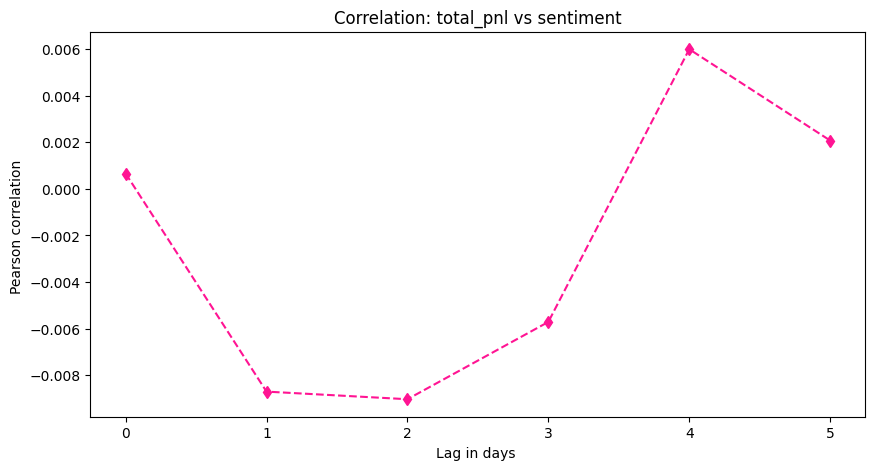

In [96]:
# Lag analysis: does sentiment lead PnL?
for lag in range(0,6):
    agg[f'sent_lag_{lag}'] = agg.groupby('trader_id')['fear_greed_value'].shift(lag)

corrs = {}
for lag in range(0,6):
    col = f'sent_lag_{lag}'
    valid = agg[['total_pnl', col]].dropna()
    corrs[lag] = valid['total_pnl'].corr(valid[col]) if len(valid)>0 else np.nan

print('Correlation of total_pnl with sentiment lags (0..5):')
print(corrs)

# Plot correlations
fig, cr = plt.subplots()
cr.plot(list(corrs.keys()), list(corrs.values()), marker='d', ls='--', color='deeppink')
cr.set_xlabel('Lag in days ')
cr.set_ylabel('Pearson correlation ')
cr.set_title('Correlation: total_pnl vs sentiment')
plt.show()

K Means Clustering

Trader features sample:
                                            mean_daily_pnl  median_daily_pnl  \
trader_id                                                                      
0x083384f897ee0f19899168e3b1bec365f52a9012    66676.242499      35548.544350   
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd      920.871548        686.342345   
0x271b280974205ca63b716753467d5a371de622ab    -5869.682610       2111.177671   
0x28736f43f1e871e6aa8b1148d38d4994275d72c4      817.684040        214.195142   
0x2c229d22b100a7beb69122eed721cee9b24011dd     2444.318913        276.768700   

                                            win_rate  avg_trades_day  \
trader_id                                                              
0x083384f897ee0f19899168e3b1bec365f52a9012  0.352333      159.083333   
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  0.397134      140.000000   
0x271b280974205ca63b716753467d5a371de622ab  0.379952      317.416667   
0x28736f43f1e871e6aa8b1148d38d4994275d72c4  0.452509   

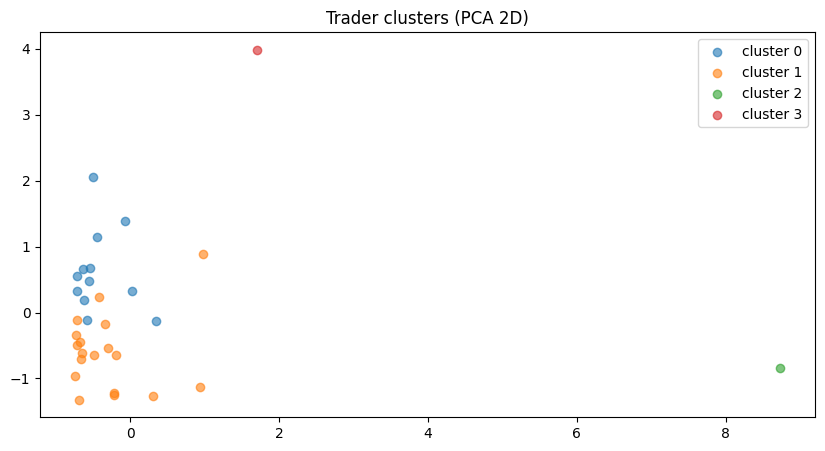


Cluster sizes:
cluster
1    18
0    12
2     1
3     1
Name: count, dtype: int64


In [97]:
# making clusters of traders by behavior
trader_feats = agg.groupby('trader_id').agg(
    mean_daily_pnl = ('total_pnl','mean'),
    median_daily_pnl = ('total_pnl','median'),
    win_rate = ('win_rate','mean'),
    avg_trades_day = ('trades_count','mean'),
    pnl_vol = ('std_pnl','mean')
).dropna()

print('Trader features sample:')
print(trader_feats.head())

scaler = StandardScaler()
X = scaler.fit_transform(trader_feats)

# Choose value of k
k = 4
km = KMeans(n_clusters=k, random_state=42)
labels = km.fit_predict(X)
trader_feats['cluster'] = labels

# PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
trader_feats['pc1'] = coords[:,0]
trader_feats['pc2'] = coords[:,1]

fig, ax = plt.subplots()
for cl in sorted(trader_feats['cluster'].unique()):
    sub = trader_feats[trader_feats['cluster']==cl]
    ax.scatter(sub['pc1'], sub['pc2'], label=f'cluster {cl}', alpha=0.6)
ax.legend()
ax.set_title('Trader clusters (PCA 2D)')
plt.show()

print('\nCluster sizes:')
print(trader_feats['cluster'].value_counts())

Regression

In [98]:
# Simple regression
reg_df = agg.dropna(subset=['total_pnl','fear_greed_value'])
reg_df = reg_df.sample(min(len(reg_df), 20000), random_state=42)  # limit size for speed

X = reg_df[['fear_greed_value','trades_count','rolling_pnl_7d']].fillna(0)
X = sm.add_constant(X)
y = reg_df['total_pnl']
model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              total_pnl   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     12.69
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           3.17e-08
Time:                        19:58:37   Log-Likelihood:                -26830.
No. Observations:                2341   AIC:                         5.367e+04
Df Residuals:                    2337   BIC:                         5.369e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2487.5198   1598.983  

Saving

In [99]:

agg.to_csv('daily_trader_analysis.csv', index=False)
trader_feats.to_csv('trader_groups.csv')